<a href="https://colab.research.google.com/github/weix0026/InventoryManagement/blob/main/RandomForestStockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 6.4 MB 37.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
#********************************
# Author: Yu Wei
# 07/15/2022
#********************************

#We will create random forest model and use it to predict tomorrow's stock prices
import seaborn as sns
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
from dateutil.relativedelta import relativedelta
from pytz import timezone

mountain = timezone('US/Mountain')

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer

import requests

url="https://www.census.gov/economic-indicators/calendar-listview.html"
df_list_kpidate = pd.read_html(url)
df_list_kpidate = df_list_kpidate[0]
df_list_kpidate.columns = df_list_kpidate.iloc[0]
df_list_kpidate = df_list_kpidate[1:]
df_list_kpidate['Release Date'] =  pd.to_datetime(df_list_kpidate['Release Date'])

currentDatetime = datetime.datetime.now(mountain)
tomorrowDatetime = (currentDatetime + datetime.timedelta(days=1)).date()
tomorrowDatetime = datetime.datetime.strftime(tomorrowDatetime, '%Y-%m-%d')
df_list_kpidate = df_list_kpidate[df_list_kpidate['Release Date'] == tomorrowDatetime]
print(df_list_kpidate)

# Those are the stocks used as explanatory variables
tickers_list = ['SPY',
                'QQQ', 'SQQQ',
                'DIA', 
                '^VIX', 
                'MSFT',"GOOGL","AAPL",
                "AMZN",
                'TSLA',
                'ARKK',
                'AMC','NFLX',
                'PYPL', 
                'FDX',
                'CAT',
                'F',
                'DIS',
                'SBUX',
                "VCR",'COST',
                "DBC",'XLE','GLD',
                'CNYA','BABA',
                'SOXX','NVDA','AMD','INTC',
                'LUV',
                "XLF",
                'TLT',
                'LMT',
               '^TNX',
                '^TYX',
               '^FVX'
                ]

# You can select the starting time of data downloads
data =  yf.download(tickers_list,'2022-01-10',currentDatetime)['Close']
data =  data.reset_index() # need to reset index 
dataV = yf.download(tickers_list,'2022-01-10',currentDatetime)['Volume']
dataV = dataV.reset_index() # need to reset index 

data=data.drop(['Date'], axis=1)
dataV=dataV.drop(['Date'], axis=1)


In [53]:
def randomForestForStock(pricedata, voldata, predictedvar):
  
  a=pricedata[predictedVar][1:]     # day t
  b=pricedata[predictedVar][0:-1]   # day t-1

  # assuming we will  use 6 days of data to predict the most present day
  y=(a.reset_index()-b.reset_index())[6:].reset_index(drop=True)
  y[predictedvar][y[predictedvar] <= 0] = 0
  y[predictedvar][y[predictedvar] >  0] = 1
  y[predictedvar] = y[predictedvar].map({1:'yes', 0:'no'})

  # x_6 is the point 6 days ago
  x_6=pricedata[0:-7].reset_index(drop=True)
  x_5=pricedata[1:-6].reset_index(drop=True)
  x_4=pricedata[2:-5].reset_index(drop=True)
  x_3=pricedata[3:-4].reset_index(drop=True)
  x_2=pricedata[4:-3].reset_index(drop=True)
  x_1=pricedata[5:-2].reset_index(drop=True)

  x_1 = x_1.add_suffix('_1')
  x_2 = x_2.add_suffix('_2')
  x_3 = x_3.add_suffix('_3')
  x_4 = x_4.add_suffix('_4')
  x_5 = x_5.add_suffix('_5')
  x_6 = x_6.add_suffix('_6')
  
  x_6_v=voldata[0:-7].reset_index(drop=True)
  x_5_v=voldata[1:-6].reset_index(drop=True)
  x_4_v=voldata[2:-5].reset_index(drop=True)
  x_3_v=voldata[3:-4].reset_index(drop=True)
  x_2_v=voldata[4:-3].reset_index(drop=True)
  x_1_v=voldata[5:-2].reset_index(drop=True)

  x_1_v = x_1_v.add_suffix('_1v')
  x_2_v = x_2_v.add_suffix('_2v')
  x_3_v = x_3_v.add_suffix('_3v')
  x_4_V = x_4_v.add_suffix('_4v')
  x_5_v = x_5_v.add_suffix('_5v')
  x_6_v = x_6_v.add_suffix('_6v')
  
  dfs = [x_1, x_2, x_3, x_4, x_5, x_6, x_1_v, x_2_v, x_3_v, x_4_v, x_5_v, x_6_v]
  x= pd.concat(dfs, axis=1).reset_index()

  clf = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 30, max_depth=5, 
                                max_features= 'auto', bootstrap = False)  

  clf.fit(x, y[predictedVar])
  y_pred_train = clf.predict(x)

  # using metrics module for accuracy calculation 
  trainAccuracy = metrics.accuracy_score(y[predictedVar], y_pred_train)
  print("Predict *********  " + predictedVar + "********")
  print("ACCURACY OF THE MODEL based on training data is: ", trainAccuracy) 

  return clf, trainAccuracy  

In [54]:
def rfpredictonnewdata(myclf):
  
  # now let's do some real world testing
  fiveDay_ago = currentDatetime - datetime.timedelta(days=11)
  data_test = yf.download(tickers_list,fiveDay_ago ,currentDatetime)['Adj Close'][-6:]
  data_testV = yf.download(tickers_list,fiveDay_ago ,currentDatetime)['Volume'][-6:]
  data_test = data_test.reset_index()
  data_testV= data_testV.reset_index()
 
  data_test=data_test.drop(['Date'], axis=1)
  data_testV = data_testV.drop(['Date'], axis=1)

  x_6_t=data_test[0:1].reset_index(drop=True)
  x_5_t=data_test[1:2].reset_index(drop=True)
  x_4_t=data_test[2:3].reset_index(drop=True)
  x_3_t=data_test[3:4].reset_index(drop=True)
  x_2_t=data_test[4:5].reset_index(drop=True)
  x_1_t=data_test[5:6].reset_index(drop=True)

  x_1_t = x_1_t.add_suffix('_1')
  x_2_t = x_2_t.add_suffix('_2')
  x_3_t = x_3_t.add_suffix('_3')
  x_4_t = x_4_t.add_suffix('_4')
  x_5_t = x_5_t.add_suffix('_5')
  x_6_t = x_6_t.add_suffix('_6')

  x_6_v=data_testV[0:1].reset_index(drop=True)
  x_5_v=data_testV[1:2].reset_index(drop=True)
  x_4_v=data_testV[2:3].reset_index(drop=True)
  x_3_v=data_testV[3:4].reset_index(drop=True)
  x_2_v=data_testV[4:5].reset_index(drop=True)
  x_1_v=data_testV[5:6].reset_index(drop=True)

  x_1_v = x_1_v.add_suffix('_1v')
  x_2_v = x_2_v.add_suffix('_2v')
  x_3_v = x_3_v.add_suffix('_3v')
  x_4_V = x_4_v.add_suffix('_4v')
  x_5_v = x_5_v.add_suffix('_5v')
  x_6_v = x_6_v.add_suffix('_6v')
  
  dfs_test = [x_1_t, x_2_t, x_3_t, x_4_t, x_5_t, x_6_t, x_1_v, x_2_v, x_3_v, x_4_v, x_5_v, x_6_v]
  x_t= pd.concat(dfs_test, axis=1).reset_index()

  y_pred_test = myclf.predict(x_t)
  y_pred_test_prob = myclf.predict_proba(x_t)  

  print("Predict *********  " + predictedVar + "**** result **** = ",  y_pred_test)
  print("Predict *********  " + predictedVar + "**** result **** = ",  y_pred_test_prob)

  return y_pred_test, y_pred_test_prob

In [ ]:
predictedVar_list = ['SPY',
                'QQQ', 'SQQQ',
                'DIA', 
                'MSFT',"GOOGL","AAPL",
                "AMZN",
                'TSLA',
                'ARKK',
                'AMC','NFLX',
                'PYPL', 
                'FDX',
                'CAT',
                #'F',
                'DIS',
                'SBUX',
                #"VCR",#'COST',
                "DBC",'XLE','GLD',
                #'CNYA','BABA',
                'SOXX','NVDA','AMD','INTC',
                'LUV',
                "XLF",
                'TLT',
                'LMT' 
                ]

#predictedVar_list = ['XLF']

# Empty list used to save the probability
predictedProb_list = []

# We will predict each stock 
for predictedVar in predictedVar_list:
  clf, trainAccuracy = randomForestForStock(data, dataV, predictedVar)
  y_pred_test, y_pred_test_prob = rfpredictonnewdata(clf)
  predictedProb_list.insert (1, [currentDatetime, predictedVar, y_pred_test_prob, trainAccuracy])

print(predictedProb_list)

printableProb = pd.DataFrame(columns=['Predicted Day','Ticker','Prob_down','Prob_up','trainAccuracy'])
index_in =0
for symbolname in predictedProb_list:
    tickername = symbolname[1]
    prob_down = symbolname[2][0][0]
    prob_up = symbolname[2][0][1]
    date_pred = str(symbolname[0].date().year)+'/'+str(symbolname[0].date().month)+'/'+str(symbolname[0].date().day)
    trainaccuracy_ticker = symbolname[3]
    predict_list =[date_pred, tickername, prob_down, prob_up,trainaccuracy_ticker, trainAccuracy]
    printableProb.loc[len(printableProb)] = predict_list

print(printableProb)

# Groupby the quality column using aggregate
# value of mean and std
qual = printableProb.groupby("Ticker").agg([np.mean, np.std])
qual.columns = [' '.join(col) for col in qual.columns]
qual = qual[['Prob_up mean','Prob_up std','trainAccuracy','trainAccuracy std']]
qual = qual.sort_values('Prob_up mean')
qual= qual.reset_index
print(qual)

<bound method DataFrame.reset_index of         Prob_up mean  Prob_up std  trainAccuracy mean
Ticker                                               
XLF         0.325775          NaN            0.795276
LMT         0.359221          NaN            0.795276
FDX         0.366878          NaN            0.803150
DIS         0.399053          NaN            0.803150
GLD         0.406178          NaN            0.724409
DIA         0.414865          NaN            0.787402
XLE         0.448460          NaN            0.708661
AMC         0.452869          NaN            0.748031
SPY         0.462666          NaN            0.779528
GOOGL       0.463461          NaN            0.826772
PYPL        0.481152          NaN            0.850394
MSFT        0.482596          NaN            0.811024
NFLX        0.488695          NaN            0.748031
LUV         0.490831          NaN            0.929134
ARKK        0.500354          NaN            0.748031
SQQQ        0.506139          NaN          

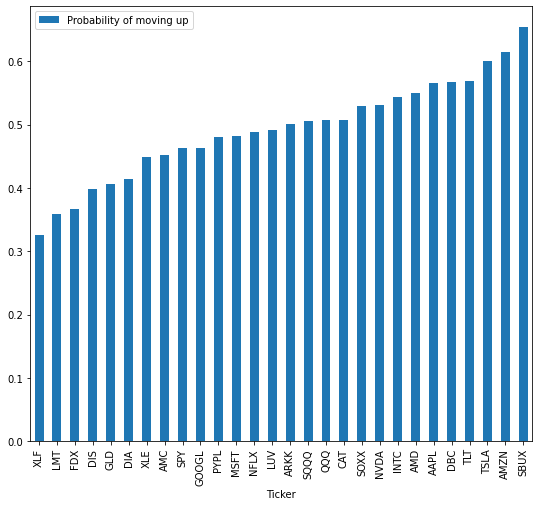

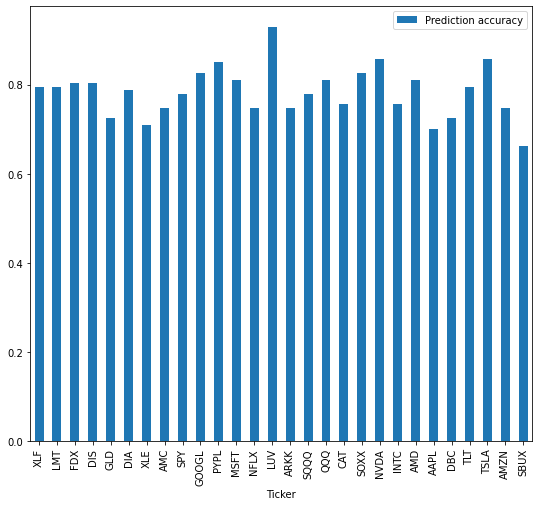

In [64]:
from google.colab import drive
import datetime

# Groupby the quality column using aggregate
# value of mean and std
qual = printableProb.groupby("Ticker").agg([np.mean, np.std])
qual.columns = [' '.join(col) for col in qual.columns]
qual = qual[['Prob_up mean','Prob_up std','trainAccuracy mean']]
qual = qual.sort_values('Prob_up mean')
qual= qual.reset_index
print(qual)

drive.mount('/content/gdrive')
strToday = (str(currentDatetime.year)+"_"+str(currentDatetime.month) + "_"  
              +str((currentDatetime + datetime.timedelta(days=-1)).day))

df=qual()
df=df.rename(columns={"Prob_up mean": "Probability of moving up"})
df.plot(x="Ticker", y=["Probability of moving up"], kind="bar", figsize=(9, 8))

images_dir = '/content/gdrive/My Drive/Investment/Figures'
plt.savefig(f"{images_dir}/IncreaseProb_{strToday}.png")
plt.savefig(f"{images_dir}/IncreaseProbMostRecent.png")

df=qual()
df=df.rename(columns={"trainAccuracy mean": "Prediction accuracy"})
df.plot(x="Ticker", y=["Prediction accuracy"], kind="bar", figsize=(9, 8))

images_dir = '/content/gdrive/My Drive/Investment/Figures'
plt.savefig(f"{images_dir}/accuracy_{strToday}.png")
plt.savefig(f"{images_dir}/accuracy.png")

In [63]:
df

,Ticker,Prob_up mean,Prob_up std,trainAccuracy mean
0,XLF,0.325775,NaN,0.795276
1,LMT,0.359221,NaN,0.795276
2,FDX,0.366878,NaN,0.803150
3,DIS,0.399053,NaN,0.803150
4,GLD,0.406178,NaN,0.724409
5,DIA,0.414865,NaN,0.787402
6,XLE,0.448460,NaN,0.708661
7,AMC,0.452869,NaN,0.748031
8,SPY,0.462666,NaN,0.779528
9,GOOGL,0.463461,NaN,0.826772
